# Tanzanian Water Wells

Overview

Access to clean water is a significant challenge in Tanzania. This analysis aims to leverage data from existing water wells across the country to identify those in need of repair. By using this data-driven approach, we seek to assist the Tanzanian government in optimizing resources and ensuring that more citizens have access to clean water.

The primary objective is to develop a predictive model that can accurately identify wells requiring maintenance. This will help reduce the time and costs associated with manually inspecting and identifying malfunctioning wells, ultimately improving water availability and quality for the people of Tanzania. At the end we will deploy our best model to predict where to build new wells.


## Import Libraries and Data

In [234]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import pickle


from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier

# Removing warnings for readability
warnings.filterwarnings("ignore")

%matplotlib inline


In [235]:
X_data_df = pd.read_csv('data/train_data.csv')
y_data_df = pd.read_csv('data/target_data.csv')

#  Describing and Visualizing the Data


In [236]:
X_data_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [237]:
X_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [238]:
y_data_df["status_group"].value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

In [239]:
y_encoded = pd.DataFrame(LabelEncoder().fit_transform(y_data_df['status_group']), columns=['target'])

In [240]:
y_encoded.value_counts(normalize=True)

target
0         0.543081
2         0.384242
1         0.072677
Name: proportion, dtype: float64

In [241]:
y_encoded = y_encoded.replace(2, 1)

In [242]:
y_encoded.value_counts(normalize=True)

target
0         0.543081
1         0.456919
Name: proportion, dtype: float64

The data has a relatively even distribution. Therefore, we will not need to use any over sampling or under sampling techniques to get an even representation between the classifications.


# Bringing the Data Together

When running machine learning algorithms, its important to separate the predictor (X) and target variables (Y) in order to train the model. The provided data is already separate, but in order to clean the data, I will be dropping a few rows that have missing information.

To ensure that the predictor and target variables are still in line, we combine the datasets before dropping any rows with missing information.


In [243]:
df = pd.concat([X_data_df, y_encoded], axis=1)

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [245]:
df.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1896
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37399
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               2695
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

# Visualizing the Data

Setting up the first basic visualization to show ratio of functioning wells to the wells in need of repair.

In [246]:
target_df = pd.DataFrame(df['target'].value_counts(normalize=True).copy())

In [247]:
target_df['Well Status'] = ['Functioning', 'Needs Repair']

In [248]:
target_df

,proportion,Well Status
target,,
0,0.543081,Functioning
1,0.456919,Needs Repair


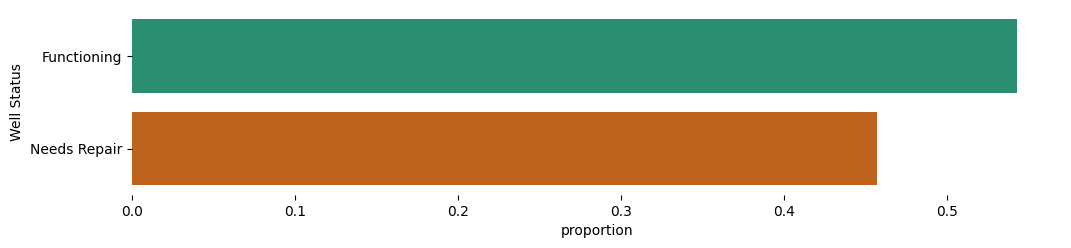

In [249]:

figsize = (12, 1.2 * len(target_df['Well Status'].unique()))
plt.figure(figsize=figsize)
sns.barplot(target_df, x='proportion', y='Well Status', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [250]:
target_df

,proportion,Well Status
target,,
0,0.543081,Functioning
1,0.456919,Needs Repair



# `waterpoint_type` Visualization


Creating a visualization of waterpoint_type percentages for Functional and Needs Repair. Communal Standpipe Multiple has the highest percentage of wells in need of repair.

When we look at the functionality of wells by the type of water point, we can clearly see that communal_standpipe_multiple wells have a lower functionality rate than the other types with 63% of wells needing repair.

Repairing these types of wells would also provide a huge benefit to the communities they’re in. These well types have multiple spigots and are designed for large groups of people to have access at once.

In [251]:
waterpoint_df = df.groupby('waterpoint_type')['target'].value_counts(normalize=True).unstack()

In [252]:
waterpoint_df = waterpoint_df.rename(columns={0: 'Functional', 1: 'Needs Repair'})

[Text(0, 0.0, '0%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.6000000000000001, '60%'),
 Text(0, 0.8, '80%'),
 Text(0, 1.0, '100%'),
 Text(0, 1.2000000000000002, '')]

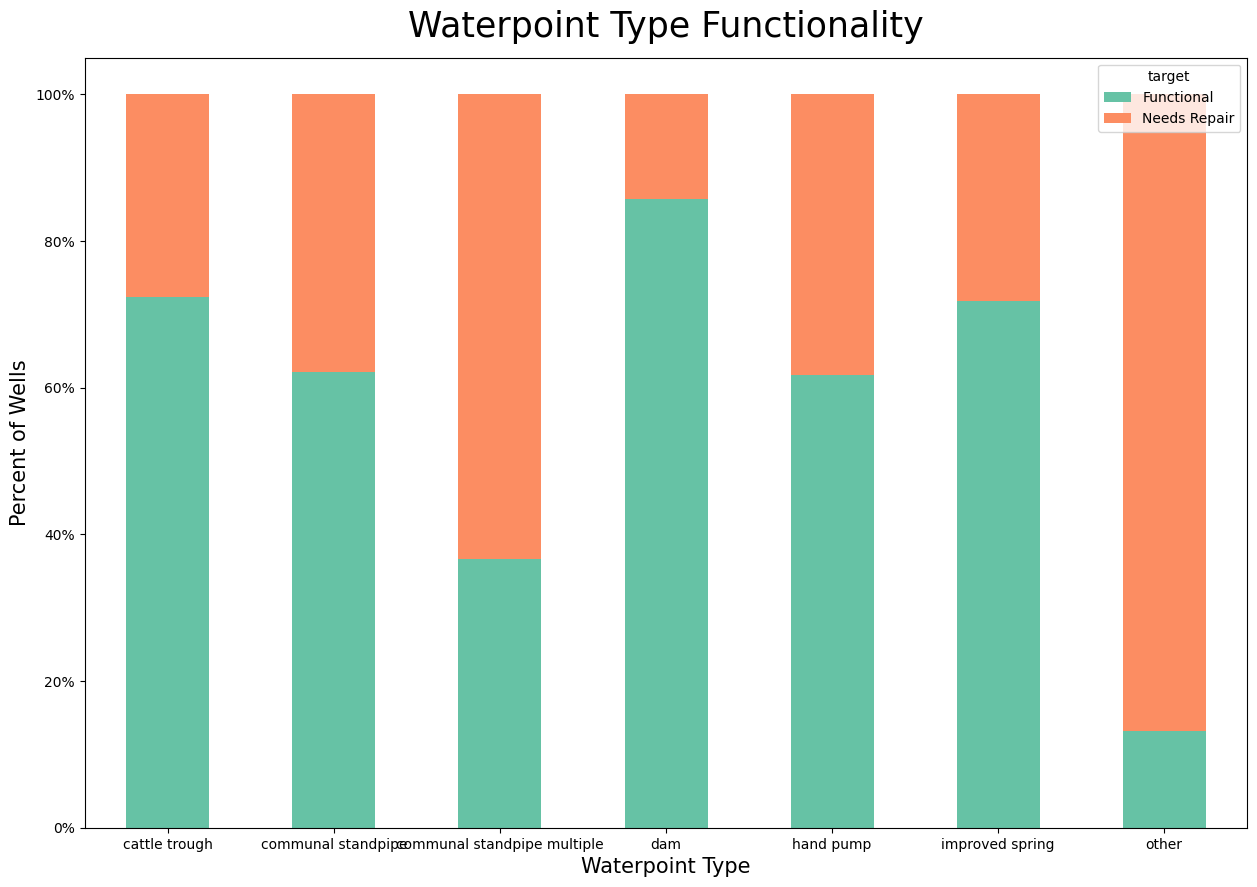

In [253]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_palette("Set2")
waterpoint_df.plot(kind='bar', stacked=True, ax=ax, rot=0)
ax.set_xlabel('Waterpoint Type', size=15)
ax.set_ylabel('Percent of Wells', size=15)
ax.set_title('Waterpoint Type Functionality', size=25, pad=15)
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# `quantity` Visualization

Creating a visualization of quantity percentages for Functional and Needs Repair types. Unknown and Dry are the two categories with the highest percentage of wells in need of repair.

When we look at the functionality of wells by the quantity of available water, we can see that almost all wells that are dried out are in need of repair. While these dry waterpoints have the highest percentage of wells that need repairing, they should not be a focus since there would be no benefit to repairing the well.

Even though only 34% of the wells that provide enough water are in need of repair, they should be the primary focus of any repair efforts.


In [254]:
quantity_df = df.groupby('quantity')['target'].value_counts(normalize=True).unstack()

In [255]:
quantity_df = quantity_df.rename(columns={0: 'Functional', 1: 'Needs Repair'})

[Text(0, 0.0, '0%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.6000000000000001, '60%'),
 Text(0, 0.8, '80%'),
 Text(0, 1.0, '100%'),
 Text(0, 1.2000000000000002, '')]

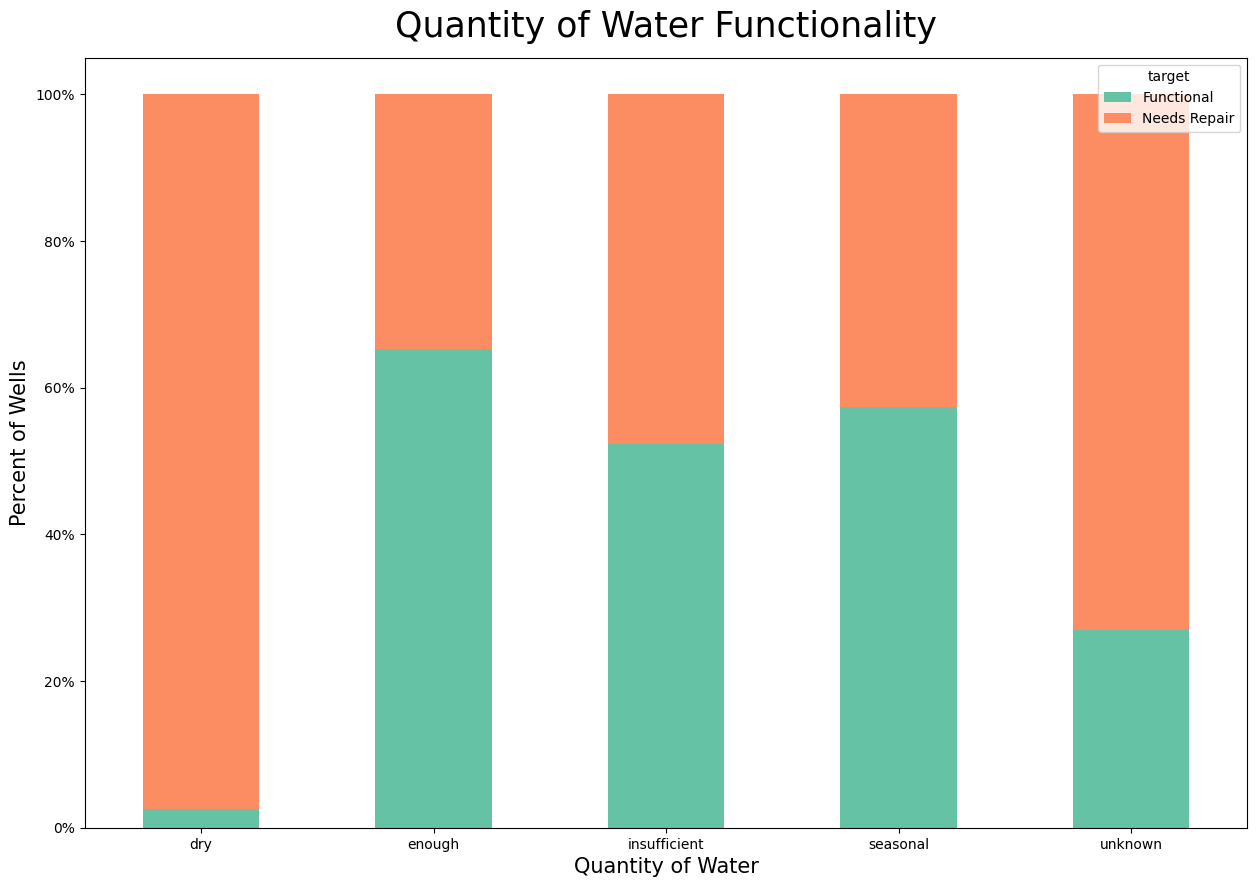

In [256]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_palette("Set2")
quantity_df.plot(kind='bar', stacked=True, ax=ax, rot=0)
ax.set_xlabel('Quantity of Water', size=15)
ax.set_ylabel('Percent of Wells', size=15)
ax.set_title('Quantity of Water Functionality', size=25, pad=15)
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# `extraction_type_class` Visualization



Creating a visualization of extraction_type_class percentages for Functional and Needs Repair types. motorpump and wind-powered are the two categories with the highest percentage of wells in need of repair.

When we look at well functionality based on the extraction type of the well we can clearly see that automatic (not man-powered) wells have a lower functionality rate than the manual powered wells.

62% of all wells extracted by motor and 57% of those extracted by wind power are in need of repair. It makes sense that the more complex wells would need repairs more often and should be a focus for inspections.

In [257]:
extraction_df = df.groupby('extraction_type_class')['target'].value_counts(normalize=True).unstack()

In [258]:
extraction_df = extraction_df.rename(columns={0: 'Functional', 1: 'Needs Repair'})

[Text(0, 0.0, '0%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.6000000000000001, '60%'),
 Text(0, 0.8, '80%'),
 Text(0, 1.0, '100%'),
 Text(0, 1.2000000000000002, '')]

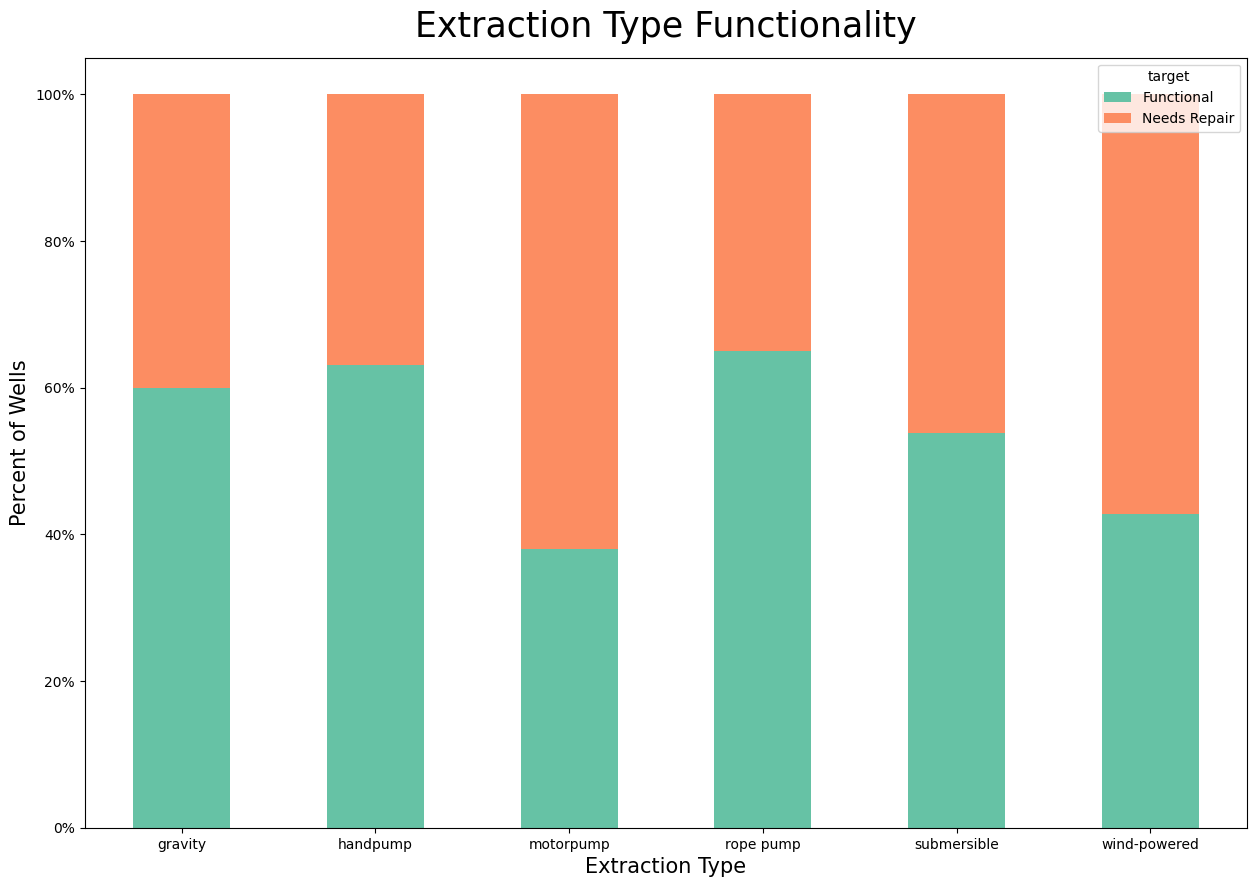

In [259]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_palette("Set2")
extraction_df.drop('other', axis=0).plot(kind='bar', stacked=True, ax=ax, rot=0)
ax.set_xlabel('Extraction Type', size=15)
ax.set_ylabel('Percent of Wells', size=15)
ax.set_title('Extraction Type Functionality', size=25, pad=15)
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


# `region` Visualization

Creating a visualization of the 5 region percentages with the most wells in need of repair. Lindi and Mtwara are the two regions with the highest percentage of wells in need of repair.

According to the 2012 national census, the regions have a combined population of over 2,000,000.

70% of all wells in Lindi and Mtwara are in need of repair. Efforts should be made to focus on well repairs in these regions first.


In [260]:
region_df = df.groupby('region')['target'].value_counts(normalize=True).unstack()

In [261]:
region_df = region_df.rename(columns={0: 'Functional', 1: 'Needs Repair'})

In [262]:
region_df_clean = region_df.sort_values(by='Needs Repair', ascending=False).head(5)

[Text(0, 0.0, '0%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.6000000000000001, '60%'),
 Text(0, 0.8, '80%'),
 Text(0, 1.0, '100%'),
 Text(0, 1.2000000000000002, '')]

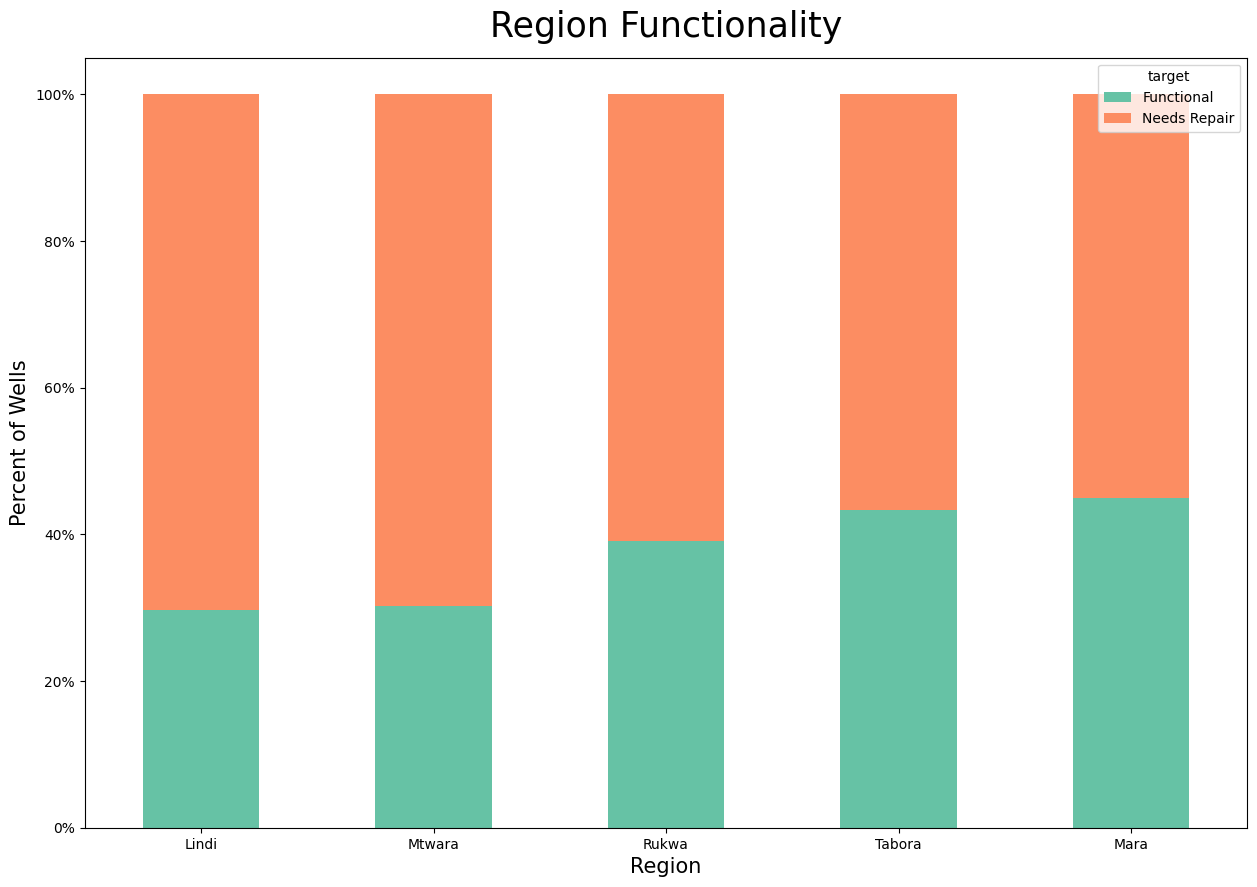

In [263]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_palette("Set2")
region_df_clean.plot(kind='bar', stacked=True, ax=ax, rot=0)
ax.set_xlabel('Region', size=15)
ax.set_ylabel('Percent of Wells', size=15)
ax.set_title('Region Functionality', size=25, pad=15)
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# Dropping Columns



To ensure that we are reducing the noise in the dataset while simultaneously being cognizant of computing time, we are removing a few columns that are not relevant to this analysis:

  * scheme_name - Who operates the waterpoint.
      This feature is missing a lot of data and the operator of the well should no impact the functionality of the well.
  * id - A unique identifier number for each well.
      The id code will not impact the well's functionality.
  * date_recorded - The date the row was entered.
      This is just data for when the information was recorded. This shouldn't have an effect on the well's functionality.
  * funder - Who funded the well.
      Who paid for the well should not impact the functionality of the well.
  * recorded_by - Group entering this row of data.
      The group who's taking notes on the wells would not affect the data itself.
  * wpt_name - Name of the waterpoint if there is one.
      Similar to id, the name of the waterpoint should not affect the functionality.
  * region, subvillage, ward, lga, and basin - Geographic location.
      The geographic location of the well is already recorded through the features latitude and longitude as well as region_code and district_code.
  * quality_group - The quality of water.
      The water quality is recorded more accurately in the water_quality feature.
  * quantity_group - The quantity of water.
      The water quantity is recorded more accurately in the water_quantity feature.
  * installer - Organization that installed the well.
      The organization in charge of installing the well does not impact its continued maintenance.
  * source_type and source_class - The source of the water.
      The source is recorded more accurately in the source feature.
  * waterpoint_type_group - The kind of waterpoint.
      The waterpoint type group is recorded more accurately in the waterpoint_type feature.
  * extraction_type_group and extraction_type_class - The kind of extraction the waterpoint uses.
      The kind of extraction is recorded more accurately in the extraction_type feature.
  * management_group - How the waterpoint is managed.
      Management is recorded more accurately in the management feature.
  * payment_type - What the water costs.
      Payment is recorded more accurately in the payment feature.




In [264]:
cols_to_drop = ['scheme_name', 'id', 'date_recorded', 'region', 'funder', 'recorded_by'
                , 'wpt_name', 'subvillage', 'ward', 'lga', 'basin', 'quality_group',
                'quantity_group', 'installer', 'source_type', 'source_class',
                'waterpoint_type_group', 'extraction_type_group',
                'extraction_type_class', 'management_group', 'payment_type']
df_dropped = df.drop(cols_to_drop, axis=1)


# Addressing Missing Values

The remaining features will have their information imputed based on the most frequent value in each category. I have decided to impute rather than drop the rows because each of the remaining features with missing values has a clearly identified 'most frequent' unique value. Also, in order to maintain the size and integrity of the dataset.

In order to avoid potential data leakage from imputing these values, the missing data will be replaced later in this analysis through a pipeline after splitting training and test data.


In [265]:
df_dropped.nunique()

amount_tsh              98
gps_height            2428
longitude            57516
latitude             57517
num_private             65
region_code             27
district_code           20
population            1049
public_meeting           2
scheme_management       11
permit                   2
construction_year       55
extraction_type         18
management              12
payment                  7
water_quality            8
quantity                 5
source                  10
waterpoint_type          7
target                   2
dtype: int64

In [266]:
df_dropped.isna().sum()

amount_tsh              0
gps_height              0
longitude               0
latitude                0
num_private             0
region_code             0
district_code           0
population              0
public_meeting       3334
scheme_management    3878
permit               3056
construction_year       0
extraction_type         0
management              0
payment                 0
water_quality           0
quantity                0
source                  0
waterpoint_type         0
target                  0
dtype: int64


# Column Dtypes

This dataset contains a wide variety of informational types. For the purpose of this analysis, I have recategorized two features from numerical types to categorical:

  * `region_code`: A codified descriptor for the waterpoint's region.
  * `district_code`: A codified descriptor for the waterpoint's district.



In [267]:
df_dropped.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.456919
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.498145
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,0.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,1.000000


In [268]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   gps_height         59400 non-null  int64  
 2   longitude          59400 non-null  float64
 3   latitude           59400 non-null  float64
 4   num_private        59400 non-null  int64  
 5   region_code        59400 non-null  int64  
 6   district_code      59400 non-null  int64  
 7   population         59400 non-null  int64  
 8   public_meeting     56066 non-null  object 
 9   scheme_management  55522 non-null  object 
 10  permit             56344 non-null  object 
 11  construction_year  59400 non-null  int64  
 12  extraction_type    59400 non-null  object 
 13  management         59400 non-null  object 
 14  payment            59400 non-null  object 
 15  water_quality      59400 non-null  object 
 16  quantity           594

In [269]:
to_object = ['region_code', 'district_code']
df_clean = df_dropped.copy()

df_clean[to_object] = df_clean[to_object].astype(object)



We now have perfectly clean data with no data leakage:

  * The target variable has been Label Encoded.
  * Dropped irrelevant columns.
  * Column Dtypes have been reassigned for categorical columns.



# Separating the Data
Now that the dataset has been cleaned we can begin the final preparations before beginning modeling. First, we need to separate the predictor and target variables again, then split the data into training and test groups.

In [270]:
y = df_clean['target']
X = df_clean.drop(['target'], axis =1)

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


# Setting up Pipelines

To streamline the analysis, reduce the potential for data leakage, and ensure that all preprocessing steps are completed with each model, I have set up a pipeline. The pipeline begins by separating the numerical data from the categorical data, once separate, the two types of data can undergo their respective preprocessing.

  * Numerical Data:
   *     The columns for numerical data or not missing any values so there is no need to include an imputer.
    *    `StandardScaler` is being utilized to standardize and scale all numerical data.

  * Categorical Data:
      * `SimpleImputer` is being utilized to fill missing data in the categorical columns based on the most frequent value within that column. A 'missing' indicator is in place to help identify that the data was not originally found within the dataset.
      * `OneHotEncoder` is being utilized to convert the categorical information to a binary system for modeling.



In [272]:
# Define the preprocessing steps
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Add imputer for numerical data
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipe', num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

# Machine learning
## Baseline Model

To begin analysis of the data, I have set up a first simple model to compare later models to. This is the bare minimum model that predicts that the most frequent target variable as the answer for all inputs.

In [273]:
dummy_model = Pipeline([
    ('col_trans', col_trans),
    ('dummy', DummyClassifier(strategy='most_frequent', random_state=42))
])

In [274]:
dummy_model.fit(X_train, y_train);

In [275]:
y_test.value_counts(normalize=True)

target
0    0.54532
1    0.45468
Name: proportion, dtype: float64

In [276]:
dummy_model.score(X_test, y_test)

0.5453198653198653


# Machine Learning Models

Now that the baseline model has been established, I need to create baseline models for each of the Machine Learning Algorithms I plan to use. These baseline models will act as a benchmark.

I will use the following models:

   * Decision Trees
   * Random Forests
   * AdaBoost
   * XGBoost
   * MLP Classifier



In [277]:


# Define the models
models = [
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(),
    AdaBoostClassifier(),
    xgboost.XGBClassifier(random_state=42)
]

# Dictionary to store model names and their corresponding accuracy scores
scores = {}

# Iterate over each model, create a pipeline, fit, and evaluate
for model in models:
    pipeline = Pipeline([
        ('preprocessor', col_trans),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    scores[model.__class__.__name__] = score
    print(f"{model.__class__.__name__}: {score}")

# Find the model with the maximum score
model_with_max_score = max(scores, key=scores.get)
print(f"{model_with_max_score} has the maximum score of {scores[model_with_max_score]}")


DecisionTreeClassifier: 0.7472727272727273
RandomForestClassifier: 0.8155555555555556
MLPClassifier: 0.790976430976431
AdaBoostClassifier: 0.7432323232323232
XGBClassifier: 0.8041750841750842
RandomForestClassifier has the maximum score of 0.8155555555555556


In [284]:
# Get the best model instance from the models list
best_model = next(model for model in models if model.__class__.__name__ == model_with_max_score)

# Train and save the best model 

for our 'app.py' we save the best model to make live predictions

In [279]:

# Predict using the best model
pipeline_best_model = Pipeline([
    ('preprocessor', col_trans),
    ('classifier', best_model)
])
pipeline_best_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F872B94450>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F872B94610>)])),
                ('classifier', RandomForestClassifier())])

In [280]:
# Sla het model op
with open('best_model.pkl', 'wb') as f:
    pickle.dump(pipeline_best_model, f)